# Phase 3 - Modeling

**Note 1: the following starting code only generates a single random train/test split when default_seed is used. You need to modify the code to generate 100 independent train/test splits with different seeds and report the average results on those independent splits along with standard deviation.**

**Note 2: You are completely free to use your own implementation.**

In [6]:
# Load general utilities
# ----------------------
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.axes as ax
import datetime
import numpy as np
import pickle
import time
import seaborn as sns

# Load sklearn utilities
# ----------------------
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, brier_score_loss, mean_squared_error, r2_score

from sklearn.calibration import calibration_curve

# Load classifiers
# ----------------
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier

# Other Packages
# --------------
from scipy.stats import kendalltau
from sklearn.neural_network import MLPRegressor
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import KMeans
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
from scipy.interpolate import spline

# Load debugger, if required
#import pixiedust
pd.options.mode.chained_assignment = None #'warn'

# suppress all warnings
import warnings
warnings.filterwarnings("ignore")

In [7]:
# Define a function that, given a CVGridSearch object, finds the
# percentage difference between the best and worst scores
def find_score_variation(cv_model):
    all_scores = cv_model.cv_results_['mean_test_score']
    return( np.abs((max(all_scores) - min(all_scores))) * 100 / max(all_scores) )

    '''
    which_min_score = np.argmin(all_scores)
    
    all_perc_diff = []
    
    try:
        all_perc_diff.append( np.abs(all_scores[which_min_score - 1] - all_scores[which_min_score])*100 / min(all_scores) )
    except:
        pass
    
    try:
        all_perc_diff.append( np.abs(all_scores[which_min_score + 1] - all_scores[which_min_score])*100 / min(all_scores) )
    except:
        pass
    
    return ( np.mean(all_perc_diff) )
    '''

# Define a function that checks, given a CVGridSearch object,
# whether the optimal parameters lie on the edge of the search
# grid????
def find_opt_params_on_edge(cv_model):
    out = False
    
    for i in cv_model.param_grid:
        if cv_model.best_params_[i] in [ cv_model.param_grid[i][0], cv_model.param_grid[i][-1] ]:
            out = True
            break
            
    return out

## Define a default random seed and an output file

In [8]:
default_seed = 1
output_file = "output_sample"

In [9]:
# Create a function to print a line to our output file

def dump_to_output(key, value):
    with open(output_file, "a") as f:
        f.write(",".join([str(default_seed), key, str(value)]) + "\n")

## Load the data and engineer the features

In [10]:
# Read the data and features from the pickle file saved in CS-Phase 2
data, discrete_features, continuous_features, ret_cols = pickle.load( open( "clean_data.pickle", "rb" ) )

In [11]:
data.loan_status.unique()

array(['Fully Paid', 'Charged Off', 'Default'], dtype=object)

In [12]:
## Create the outcome columns: True if loan_status is either Charged Off or Default, False otherwise
data["outcome"] = np.where((data['loan_status'] == "Charged Off") | (data['loan_status']== "Default"), True, False)

In [13]:
data["outcome"].unique()

array([False,  True])

In [14]:
# Create a feature for the length of a person's credit history at the time the loan is issued
data['cr_hist'] = (data.issue_d - data.earliest_cr_line) / np.timedelta64(1, 'M')
continuous_features.append('cr_hist')

In [15]:
# Randomly assign each row to a training and test set. We do this now because we will be fitting a variety of models on various time periods, and we would like every period to use the *same* training/test split
np.random.seed(default_seed)
## create the train columns where the value is True if it is a train instance and False otherwise. Hint: use np.random.choice with 70% for training and 30% for testing
data['train'] = [True if int(np.random.choice([0, 1], 1, p = [0.7,0.3])) == 0 
                      else False for i in range(data.shape[0])]

In [16]:
# Create a matrix of features and outcomes, with dummies. Record the names of the dummies for later use
X_continuous = data[continuous_features].values

X_discrete = pd.get_dummies(data[discrete_features], dummy_na = True, prefix_sep = "::", drop_first = True)
discrete_features_dummies = X_discrete.columns.tolist()
X_discrete = X_discrete.values

X = np.concatenate( (X_continuous, X_discrete), axis = 1 )

y = data.outcome.values

train = data.train.values

In [17]:
print("#num of continous features ", X_continuous[0,:].shape[0])
print("#num of continous features ", X_discrete[0,:].shape[0])

#num of continous features  20
#num of continous features  43


## Prepare functions to fit and evaluate models

In [18]:
def prepare_data(data_subset = np.array([True]*len(data)),
                    n_samples_train = 30000,
                    n_samples_test = 20000,
                    feature_subset = None,
                    date_range_train = (data.issue_d.min(), data.issue_d.max()),
                    date_range_test = (data.issue_d.min(), data.issue_d.max()),
                    random_state = default_seed):
    '''
    This function will prepare the data for classification or regression.
    It expects the following parameters:
      - data_subset: a numpy array with as many entries as rows in the
                     dataset. Each entry should be True if that row
                     should be used, or False if it should be ignored
      - n_samples_train: the total number of samples to be used for training.
                         Will trigger an error if this number is larger than
                         the number of rows available after all filters have
                         been applied
      - n_samples_test: as above for testing
      - feature_subect: A list containing the names of the features to be
                        used in the model. In None, all features in X are
                        used
      - date_range_train: a tuple containing two dates. All rows with loans
                          issued outside of these two dates will be ignored in
                          training
      - date_range_test: as above for testing
      - random_state: the random seed to use when selecting a subset of rows
      
    Note that this function assumes the data has a "Train" column, and will
    select all training rows from the rows with "True" in that column, and all
    the testing rows from those with a "False" in that column.
    
    This function returns a dictionary with the following entries
      - X_train: the matrix of training data
      - y_train: the array of training labels
      - train_set: a Boolean vector with as many entries as rows in the data
                  that denotes the rows that were used in the train set
      - X_test: the matrix of testing data
      - y_test: the array of testing labels
      - test_set: a Boolean vector with as many entries as rows in the data
                  that denotes the rows that were used in the test set
    '''
    
    np.random.seed(random_state)
        
    # Filter down the data to the required date range, and downsample
    # as required
  
    filter_train = ( train & (data.issue_d >= date_range_train[0]) & (data.issue_d <= date_range_train[1]) & data_subset ).values
    filter_test = ( (train == False) & (data.issue_d >= date_range_test[0]) & (data.issue_d <= date_range_test[1]) & data_subset ).values
    
    filter_train[ np.random.choice( np.where(filter_train)[0], size = filter_train.sum()
                                                   - n_samples_train, replace = False ) ] = False
    filter_test[ np.random.choice( np.where(filter_test)[0], size = filter_test.sum()
                                                   - n_samples_test, replace = False ) ] = False
    
    # Prepare the training and test set
    X_train = X[ filter_train , :]
    X_test = X[ filter_test, :]
    if feature_subset != None:
        cols = [i for i, j in enumerate(continuous_features + discrete_features_dummies)
                                                     if j.split("::")[0] in feature_subset]
        X_train = X_train[ : , cols ]
        X_test = X_test[ : , cols ]
        
    y_train = y[ filter_train ]
    y_test = y[ filter_test ]
    
    # Scale the variables
    scaler = preprocessing.MinMaxScaler()

    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    # return training and testing data
    out = {'X_train':X_train, 'y_train':y_train, 'train_set':filter_train, 
           'X_test':X_test, 'y_test':y_test, 'test_set':filter_test}
    
    return out

In [19]:
def fit_classification(model, data_dict,
                          cv_parameters = {},
                          model_name = None,
                          random_state = default_seed,
                          output_to_file = True,
                          print_to_screen = True):
    '''
    This function will fit a classification model to data and print various evaluation
    measures. It expects the following parameters
      - model: an sklearn model object
      - data_dict: the dictionary containing both training and testing data;
                   returned by the prepare_data function
      - cv_parameters: a dictionary of parameters that should be optimized
                       over using cross-validation. Specifically, each named
                       entry in the dictionary should correspond to a parameter,
                       and each element should be a list containing the values
                       to optimize over
      - model_name: the name of the model being fit, for printouts
      - random_state: the random seed to use
      - output_to_file: if the results will be saved to the output file
      - print_to_screen: if the results will be printed on screen
    
    If the model provided does not have a predict_proba function, we will
    simply print accuracy diagnostics and return.
    
    If the model provided does have a predict_proba function, we first
    figure out the optimal threshold that maximizes the accuracy and
    print out accuracy diagnostics. We then print an ROC curve, sensitivity/
    specificity curve, and calibration curve.
    
    This function returns a dictionary with the following entries
      - model: the best fitted model
      - y_pred: predictions for the test set
      - y_pred_probs: probability predictions for the test set, if the model
                      supports them
      - y_pred_score: prediction scores for the test set, if the model does not 
                      output probabilities.
    '''
        
    np.random.seed(random_state)
    
    # --------------------------
    #   Step 1 - Load the data
    # --------------------------
    X_train = data_dict['X_train']
    y_train = data_dict['y_train']
    
    X_test = data_dict['X_test']
    y_test = data_dict['y_test']
    
    filter_train = data_dict['train_set']    
  
    # --------------------------
    #   Step 2 - Fit the model
    # --------------------------

    cv_model = GridSearchCV(model, cv_parameters)
    
    start_time = time.time()
    cv_model.fit(X_train, y_train)
    end_time = time.time()
    
    best_model = cv_model.best_estimator_
    
    if print_to_screen:

        if model_name != None:
            print("=========================================================")
            print("  Model: " + model_name)
            print("=========================================================")

        print("Fit time: " + str(round(end_time - start_time, 2)) + " seconds")
        print("Optimal parameters:")
        print(cv_model.best_params_)
        print("")
    
    # -------------------------------
    #   Step 3 - Evaluate the model
    # -------------------------------
    
    # If possible, make probability predictions
    try:
        y_pred_probs = best_model.predict_proba(X_test)[:,1]
        fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
        
        probs_predicted = True
    except:
        probs_predicted = False
    
    # Make predictions; if we were able to find probabilities, use
    # the threshold that maximizes the accuracy in the training set.
    # If not, just use the learner's predict function
    if probs_predicted:
        y_train_pred_probs = best_model.predict_proba(X_train)[:,1]
        fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_pred_probs)
        
        true_pos_train = tpr_train*(y_train.sum())
        true_neg_train = (1 - fpr_train) *(1-y_train).sum()
        
        best_threshold_index = np.argmax(true_pos_train + true_neg_train)
        best_threshold = 1 if best_threshold_index == 0 else thresholds_train[ best_threshold_index ]
        
        if print_to_screen:
            print("Accuracy-maximizing threshold was: " + str(best_threshold))
        
        y_pred = (y_pred_probs > best_threshold)
    else:
        y_pred = best_model.predict(X_test)
    
    if print_to_screen:
        print("Accuracy: ", accuracy_score(y_test, y_pred))
        print(classification_report(y_test, y_pred, target_names =['No default', 'Default'], digits = 4))

    if print_to_screen:
        if probs_predicted:        
            plt.figure(figsize = (13, 4.5))
            plt.subplot(2, 2, 1)

            plt.title("ROC Curve (AUC = %0.2f)"% roc_auc_score(y_test, y_pred_probs))
            plt.plot(fpr, tpr, 'b')
            plt.plot([0,1],[0,1],'r--')
            plt.xlim([0,1]); plt.ylim([0,1])
            plt.ylabel('True Positive Rate')
            plt.xlabel('False Positive Rate')

            plt.subplot(2, 2, 3)

            plt.plot(thresholds, tpr, 'b', label = 'Sensitivity')
            plt.plot(thresholds, 1 -fpr, 'r', label = 'Specificity')
            plt.legend(loc = 'lower right')
            plt.xlim([0,1]); plt.ylim([0,1])
            plt.xlabel('Threshold')

            plt.subplot(2, 2, 2)

            fp_0, mpv_0 = calibration_curve(y_test, y_pred_probs, n_bins = 10)
            plt.plot([0,1], [0,1], 'k:', label='Perfectly calibrated')
            plt.plot(mpv_0, fp_0, 's-')
            plt.ylabel('Fraction of Positives')
            plt.xlim([0,1]); plt.ylim([0,1])
            plt.legend(loc ='upper left')
            
            plt.subplot(2, 2, 4)
            plt.hist(y_pred_probs, range=(0, 1), bins=10, histtype="step", lw=2)
            plt.xlim([0,1]); plt.ylim([0,20000])
            plt.xlabel('Mean Predicted Probability')
            plt.ylabel('Count')
            
            #plt.tight_layout()
            plt.show()
        
    # Additional Score Check
    if probs_predicted:
        y_train_score = y_train_pred_probs
    else:
        y_train_score = best_model.decision_function(X_train)
        
    tau, p_value = kendalltau(y_train_score, data.grade[filter_train])
    if print_to_screen:
        print("")
        print("Similarity to LC grade ranking: ", tau)
    
    if probs_predicted:
        brier_score = brier_score_loss(y_test, y_pred_probs)
        if print_to_screen:
            print("Brier score:", brier_score)
    
    # Return the model predictions, and the
    # test set
    # -------------------------------------
    out = {'model':best_model, 'y_pred_labels':y_pred}
    
    if probs_predicted:
        out.update({'y_pred_probs':y_pred_probs})
    else:
        y_pred_score = best_model.decision_function(X_test)
        out.update({'y_pred_score':y_pred_score})
        
    # Output results to file
    # ----------------------
    if probs_predicted and output_to_file:
        # Check whether any of the CV parameters are on the edge of
        # the search space
        opt_params_on_edge = find_opt_params_on_edge(cv_model)
        dump_to_output(model_name + "::search_on_edge", opt_params_on_edge)
        if print_to_screen:
            print("Were parameters on edge? : " + str(opt_params_on_edge))
        
        # Find out how different the scores are for the different values
        # tested for by cross-validation. If they're not too different, then
        # even if the parameters are off the edge of the search grid, we should
        # be ok
        score_variation = find_score_variation(cv_model)
        dump_to_output(model_name + "::score_variation", score_variation)
        if print_to_screen:
            print("Score variations around CV search grid : " + str(score_variation))
        
        # Print out all the scores
        dump_to_output(model_name + "::all_cv_scores", str(cv_model.cv_results_['mean_test_score']))
        if print_to_screen:
            print( str(cv_model.cv_results_['mean_test_score']) )
        
        # Dump the AUC to file
        dump_to_output(model_name + "::roc_auc", roc_auc_score(y_test, y_pred_probs) )
        
    return out

## Train and Test different machine learning classification models

The machine learning models listed in the following are just our suggestions. You are free to try any other models that you would like to experiment with.

In [16]:
## define your set of features to use in different models
your_features = ['loan_amnt', 'funded_amnt', 'term', 'int_rate', 'installment', 'grade', 'emp_length',
                'home_ownership', 'annual_inc', 'verification_status', 'purpose', 'dti', 
                'delinq_2yrs', 'open_acc', 'pub_rec', 'fico_range_high', 'fico_range_low', 
                'revol_bal', 'revol_util','cr_hist']
# prepare the train, test data for training models
data_dict = prepare_data(feature_subset = your_features)

all_features = pd.Series(continuous_features + discrete_features_dummies)
idx = [i for i, j in enumerate(continuous_features + discrete_features_dummies)
                                                     if j.split("::")[0] in your_features]
selected_features = all_features[idx]
selected_features.reset_index(drop=True,inplace=True)

In [17]:
selected_features

0                                loan_amnt
1                              funded_amnt
2                              installment
3                               annual_inc
4                                      dti
5                              delinq_2yrs
6                                 open_acc
7                                  pub_rec
8                          fico_range_high
9                           fico_range_low
10                               revol_bal
11                                int_rate
12                              revol_util
13                                 cr_hist
14                   emp_length::10+ years
15                     emp_length::2 years
16                     emp_length::3 years
17                     emp_length::4 years
18                     emp_length::5 years
19                     emp_length::6 years
20                     emp_length::7 years
21                     emp_length::8 years
22                     emp_length::9 years
23         

### Naive Bayes

Fit time: 0.34 seconds
Optimal parameters:
{}

Accuracy-maximizing threshold was: 1
Accuracy:  0.7904
              precision    recall  f1-score   support

  No default     0.7904    1.0000    0.8829     15808
     Default     0.0000    0.0000    0.0000      4192

   micro avg     0.7904    0.7904    0.7904     20000
   macro avg     0.3952    0.5000    0.4415     20000
weighted avg     0.6247    0.7904    0.6979     20000



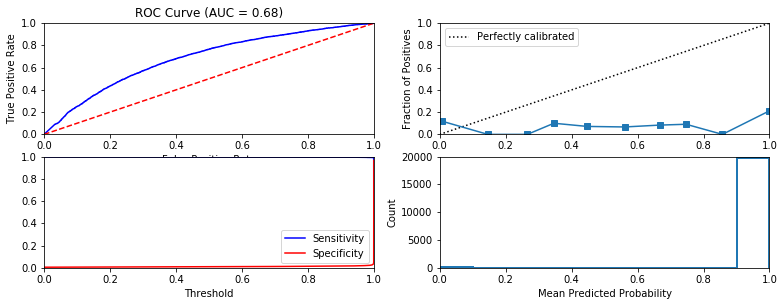


Similarity to LC grade ranking:  0.6571432558259243
Brier score: 0.7811850869638124


In [18]:
## Train and test a naive bayes classifier

gnb = GaussianNB()
gnb = fit_classification(gnb, data_dict,
                          cv_parameters = {},
                          model_name = None,
                          random_state = default_seed,
                          output_to_file = False,
                          print_to_screen = True)

### $l_1$ regularized logistic regression

Fit time: 20.01 seconds
Optimal parameters:
{'C': 10}

Accuracy-maximizing threshold was: 0.5052144205987511
Accuracy:  0.79385
              precision    recall  f1-score   support

  No default     0.7990    0.9877    0.8834     15808
     Default     0.5755    0.0627    0.1131      4192

   micro avg     0.7938    0.7938    0.7938     20000
   macro avg     0.6872    0.5252    0.4983     20000
weighted avg     0.7521    0.7938    0.7219     20000



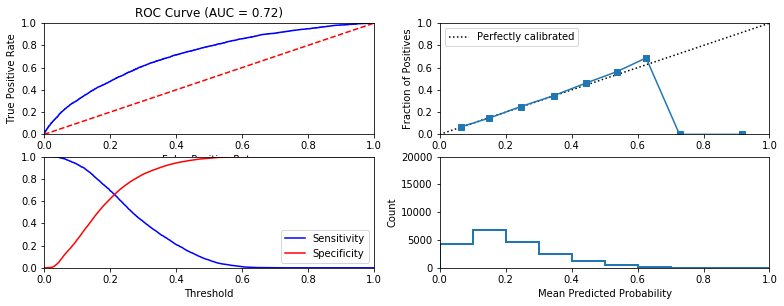


Similarity to LC grade ranking:  0.7294315722999861
Brier score: 0.14900290017912154


In [19]:
## Train and test a l_1 regularized logistic regression classifier

l1_logistic =  LogisticRegression(penalty='l1')
cv_parameters = {'C':[0.01,0.1,1,10]}

l1_logistic = fit_classification(l1_logistic, data_dict,
                          cv_parameters =cv_parameters ,
                          model_name = None,
                          random_state = default_seed,
                          output_to_file = False,
                          print_to_screen = True)

### $l_2$ regularized logistic regression

Fit time: 1.92 seconds
Optimal parameters:
{'C': 1}

Accuracy-maximizing threshold was: 0.4959047729590312
Accuracy:  0.7934
              precision    recall  f1-score   support

  No default     0.7986    0.9878    0.8832     15808
     Default     0.5673    0.0604    0.1091      4192

   micro avg     0.7934    0.7934    0.7934     20000
   macro avg     0.6829    0.5241    0.4961     20000
weighted avg     0.7501    0.7934    0.7209     20000



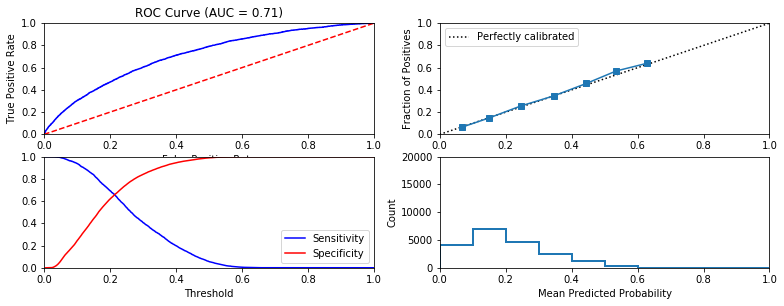


Similarity to LC grade ranking:  0.7486055099075661
Brier score: 0.1496681841969029


In [20]:
## Train and test a l_1 regularized logistic regression classifier

l2_logistic = LogisticRegression(penalty='l2')
cv_parameters = {'C':[0.01,0.1,1]}
l2_logistic = fit_classification(l2_logistic, data_dict,
                          cv_parameters =cv_parameters ,
                          model_name = None,
                          random_state = default_seed,
                          output_to_file = False,
                          print_to_screen = True)

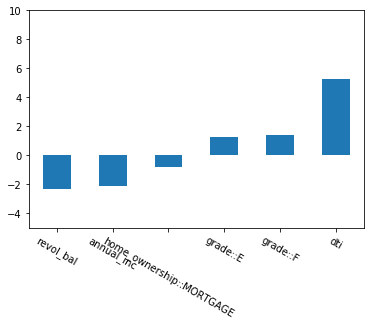

In [21]:
## plot top 3 features with the most positive (and negative) weights 
top_and_bottom_idx = list(np.argsort(l2_logistic['model'].coef_)[0,:3]) + list(np.argsort(l2_logistic['model'].coef_)[0,-3:])
bplot = pd.Series(l2_logistic['model'].coef_[0,top_and_bottom_idx])
xticks = selected_features[top_and_bottom_idx]
p1 = bplot.plot(kind='bar',rot=-30,ylim=(-5,10))
p1.set_xticklabels(xticks)
plt.show()

### Decision tree

Fit time: 6.09 seconds
Optimal parameters:
{'max_depth': 1}

Accuracy-maximizing threshold was: 1
Accuracy:  0.7904
              precision    recall  f1-score   support

  No default     0.7904    1.0000    0.8829     15808
     Default     0.0000    0.0000    0.0000      4192

   micro avg     0.7904    0.7904    0.7904     20000
   macro avg     0.3952    0.5000    0.4415     20000
weighted avg     0.6247    0.7904    0.6979     20000



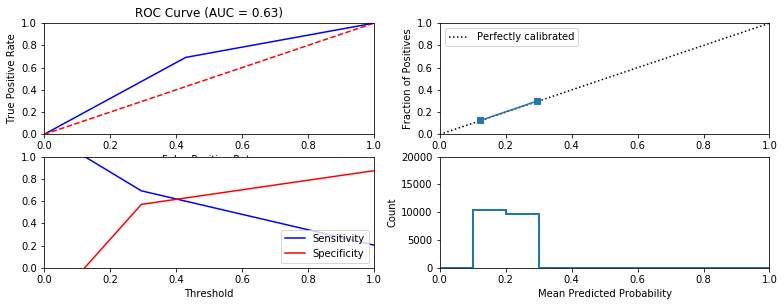


Similarity to LC grade ranking:  0.7384408233579492
Brier score: 0.15809698770880198


In [22]:
## Train and test a decision tree classifier

decision_tree = DecisionTreeClassifier()
cv_parameters = {'max_depth': range(1,20,2)}

decision_tree = fit_classification(decision_tree, data_dict,
                          cv_parameters =cv_parameters ,
                          model_name = None,
                          random_state = default_seed,
                          output_to_file = False,
                          print_to_screen = True)

### Random forest

Fit time: 7.17 seconds
Optimal parameters:
{'max_depth': 7, 'n_estimators': 10}

Accuracy-maximizing threshold was: 0.3800450886599
Accuracy:  0.79015
              precision    recall  f1-score   support

  No default     0.8074    0.9645    0.8790     15808
     Default     0.4978    0.1326    0.2095      4192

   micro avg     0.7902    0.7902    0.7902     20000
   macro avg     0.6526    0.5486    0.5442     20000
weighted avg     0.7425    0.7902    0.7387     20000



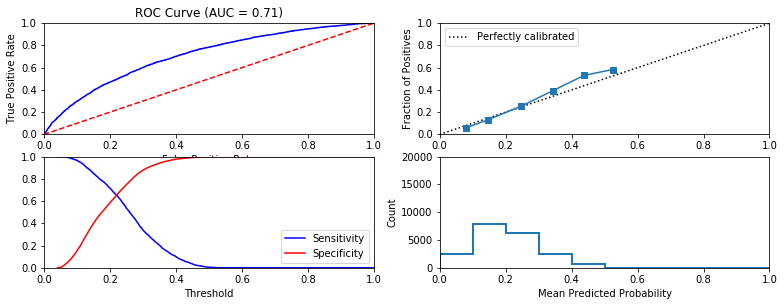


Similarity to LC grade ranking:  0.7198884118332669
Brier score: 0.1512240446035159


In [23]:
## Train and test a random forest classifier

random_forest = RandomForestClassifier()
cv_parameters = param_dist = {"n_estimators":[5,10,15,20],
              "max_depth": [3, 5,7]}

random_forest = fit_classification(random_forest, data_dict,
                          cv_parameters =cv_parameters ,
                          model_name = None,
                          random_state = default_seed,
                          output_to_file = False,
                          print_to_screen = True)

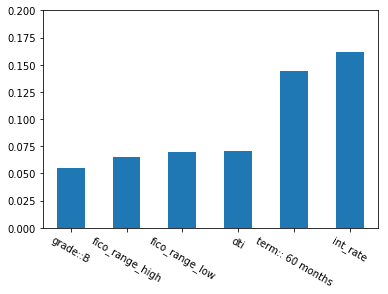

In [25]:
## Plot top 6 most significant features
top_idx = list(np.argsort(random_forest['model'].feature_importances_)[-6:]) 
bplot = pd.Series(random_forest['model'].feature_importances_[top_idx])
xticks = selected_features[top_idx]
p2 = bplot.plot(kind='bar',rot=-30,ylim=(0,0.2))
p2.set_xticklabels(xticks)
plt.show()

### Multi-layer perceptron

Fit time: 195.62 seconds
Optimal parameters:
{'activation': 'tanh', 'hidden_layer_sizes': 10}

Accuracy-maximizing threshold was: 0.5297368990414959
Accuracy:  0.79345
              precision    recall  f1-score   support

  No default     0.7984    0.9882    0.8832     15808
     Default     0.5704    0.0589    0.1068      4192

   micro avg     0.7934    0.7934    0.7934     20000
   macro avg     0.6844    0.5236    0.4950     20000
weighted avg     0.7506    0.7934    0.7205     20000



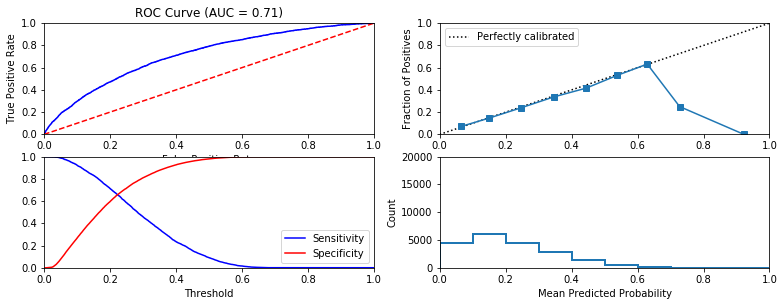


Similarity to LC grade ranking:  0.7055015586641167
Brier score: 0.14981681115915307


In [26]:
## Train and test a multi-layer perceptron classifier

mlp =MLPClassifier()
cv_parameters = {"hidden_layer_sizes":[10,50,100],"activation" : [ 'tanh', 'relu']}

mlp = fit_classification(mlp, data_dict,
                          cv_parameters =cv_parameters ,
                          model_name = None,
                          random_state = default_seed,
                          output_to_file = False,
                          print_to_screen = True)

## Train and Test logistic regression model with features derived by LendingClub

  Model: lc1_only_logreg
Fit time: 0.16 seconds
Optimal parameters:
{}

Accuracy-maximizing threshold was: 1
Accuracy:  0.7904
              precision    recall  f1-score   support

  No default     0.7904    1.0000    0.8829     15808
     Default     0.0000    0.0000    0.0000      4192

   micro avg     0.7904    0.7904    0.7904     20000
   macro avg     0.3952    0.5000    0.4415     20000
weighted avg     0.6247    0.7904    0.6979     20000



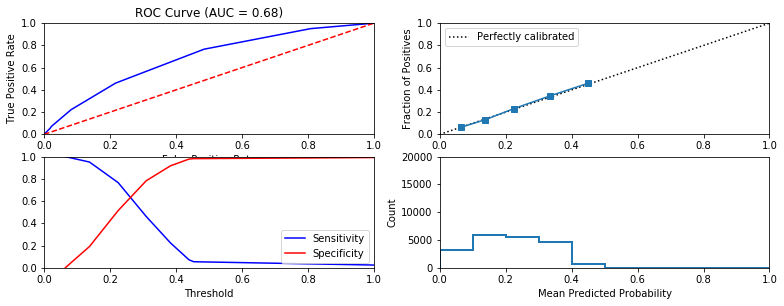


Similarity to LC grade ranking:  0.9989594722285634
Brier score: 0.15355989608852194
Were parameters on edge? : False
Score variations around CV search grid : 0.0
[0.79366667]


In [28]:
## Find a lendingClub-defined feature and train a l1-regularized logistic regression model on data with only that feature
a_lendingclub_feature = ['grade','int_rate','verification_status']
data_dict = prepare_data(feature_subset=a_lendingclub_feature[:1])
lc1_only_logistic = LogisticRegression(penalty='l1')

lc1_only_logistic = fit_classification(model=lc1_only_logistic, data_dict=data_dict, model_name='lc1_only_logreg')


  Model: lc2_only_logreg
Fit time: 0.1 seconds
Optimal parameters:
{}

Accuracy-maximizing threshold was: 1
Accuracy:  0.7904
              precision    recall  f1-score   support

  No default     0.7904    1.0000    0.8829     15808
     Default     0.0000    0.0000    0.0000      4192

   micro avg     0.7904    0.7904    0.7904     20000
   macro avg     0.3952    0.5000    0.4415     20000
weighted avg     0.6247    0.7904    0.6979     20000



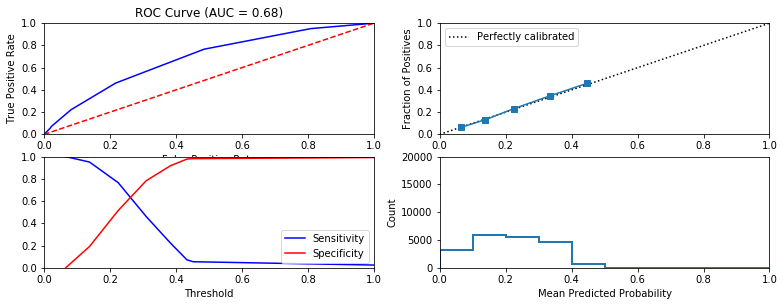


Similarity to LC grade ranking:  0.9989594722285634
Brier score: 0.15356971466138733
Were parameters on edge? : False
Score variations around CV search grid : 0.0
[0.79366667]


In [29]:
## train a l2-regularized logistic regression model on data with only that feature
lc2_only_logistic = LogisticRegression(penalty='l2')

lc2_only_logistic = fit_classification(model=lc2_only_logistic, data_dict=data_dict, model_name='lc2_only_logreg')

## Train and test all the models you have tried previously after removing features derived by LendingClub 

Fit time: 0.28 seconds
Optimal parameters:
{}

Accuracy-maximizing threshold was: 1
Accuracy:  0.7904
              precision    recall  f1-score   support

  No default     0.7904    1.0000    0.8829     15808
     Default     0.0000    0.0000    0.0000      4192

   micro avg     0.7904    0.7904    0.7904     20000
   macro avg     0.3952    0.5000    0.4415     20000
weighted avg     0.6247    0.7904    0.6979     20000



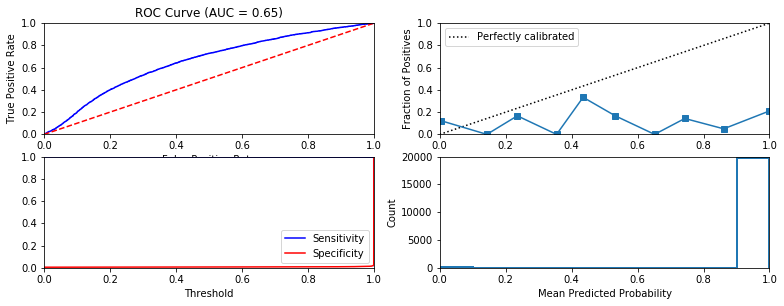


Similarity to LC grade ranking:  0.3816178009828407
Brier score: 0.7844297225270924
Fit time: 16.36 seconds
Optimal parameters:
{'C': 10}

Accuracy-maximizing threshold was: 0.4809966305270458
Accuracy:  0.7943
              precision    recall  f1-score   support

  No default     0.8036    0.9791    0.8827     15808
     Default     0.5528    0.0973    0.1655      4192

   micro avg     0.7943    0.7943    0.7943     20000
   macro avg     0.6782    0.5382    0.5241     20000
weighted avg     0.7510    0.7943    0.7324     20000



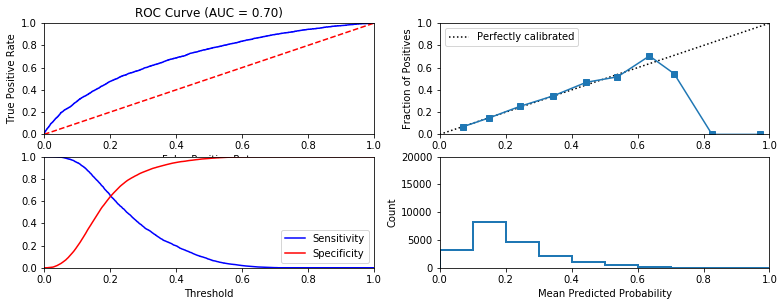


Similarity to LC grade ranking:  0.5368857071941415
Brier score: 0.15065029890501894
Fit time: 1.3 seconds
Optimal parameters:
{'C': 0.1}

Accuracy-maximizing threshold was: 0.49823822282554986
Accuracy:  0.79235
              precision    recall  f1-score   support

  No default     0.7956    0.9922    0.8831     15808
     Default     0.5684    0.0386    0.0724      4192

   micro avg     0.7923    0.7923    0.7923     20000
   macro avg     0.6820    0.5154    0.4777     20000
weighted avg     0.7480    0.7923    0.7132     20000



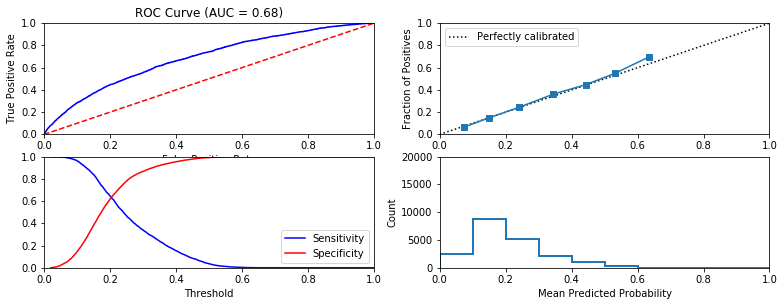


Similarity to LC grade ranking:  0.4951618350136674
Brier score: 0.15325547188388863
Fit time: 5.47 seconds
Optimal parameters:
{'max_depth': 3}

Accuracy-maximizing threshold was: 1
Accuracy:  0.7904
              precision    recall  f1-score   support

  No default     0.7904    1.0000    0.8829     15808
     Default     0.0000    0.0000    0.0000      4192

   micro avg     0.7904    0.7904    0.7904     20000
   macro avg     0.3952    0.5000    0.4415     20000
weighted avg     0.6247    0.7904    0.6979     20000



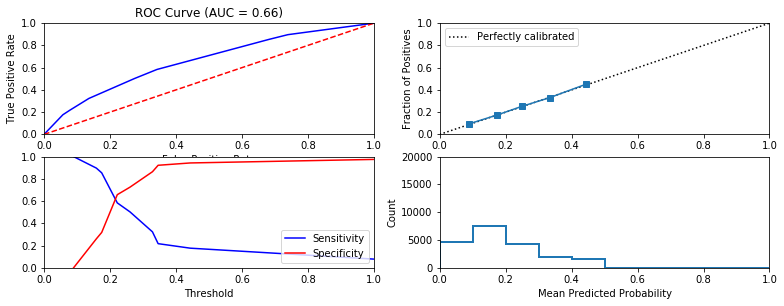


Similarity to LC grade ranking:  0.4682991219198989
Brier score: 0.15570198510393787
Fit time: 6.7 seconds
Optimal parameters:
{'max_depth': 5, 'n_estimators': 10}

Accuracy-maximizing threshold was: 0.38515294440169534
Accuracy:  0.7931
              precision    recall  f1-score   support

  No default     0.7960    0.9927    0.8835     15808
     Default     0.5951    0.0403    0.0755      4192

   micro avg     0.7931    0.7931    0.7931     20000
   macro avg     0.6955    0.5165    0.4795     20000
weighted avg     0.7538    0.7931    0.7142     20000



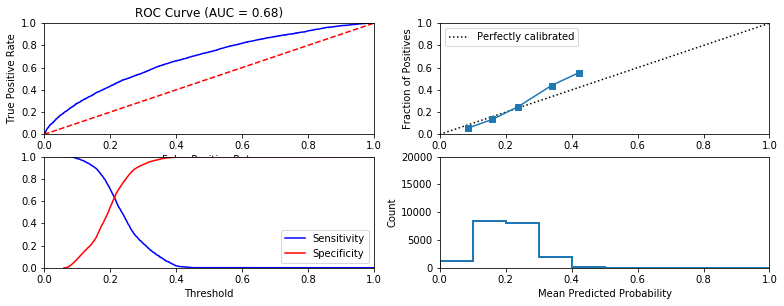


Similarity to LC grade ranking:  0.45341911023376896
Brier score: 0.15518881478615565
Fit time: 170.72 seconds
Optimal parameters:
{'activation': 'tanh', 'hidden_layer_sizes': 10}

Accuracy-maximizing threshold was: 0.4996788692539585
Accuracy:  0.7929
              precision    recall  f1-score   support

  No default     0.7986    0.9868    0.8828     15808
     Default     0.5534    0.0618    0.1112      4192

   micro avg     0.7929    0.7929    0.7929     20000
   macro avg     0.6760    0.5243    0.4970     20000
weighted avg     0.7472    0.7929    0.7211     20000



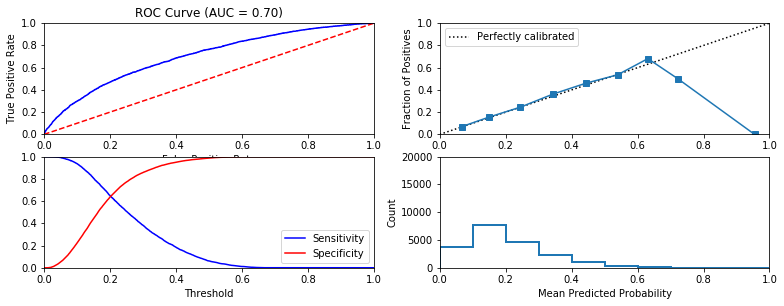


Similarity to LC grade ranking:  0.5254102252920848
Brier score: 0.15087317174059742


In [30]:
your_features_without_de = ['loan_amnt', 'funded_amnt', 'term', 'installment', 'emp_length',
                'home_ownership', 'annual_inc', 'purpose', 'dti', 
                'delinq_2yrs', 'open_acc', 'pub_rec', 'fico_range_high', 'fico_range_low', 
                'revol_bal', 'revol_util','cr_hist']
# prepare the train, test data for training models
data_dict_new = prepare_data(feature_subset = your_features_without_de)

gnb = GaussianNB()
gnb = fit_classification(gnb, data_dict_new,
                          cv_parameters = {},
                          model_name = None,
                          random_state = default_seed,
                          output_to_file = False,
                          print_to_screen = True)


l1_logistic =  LogisticRegression(penalty='l1')
cv_parameters = {'C':[0.01,0.1,1,10]}

l1_logistic = fit_classification(l1_logistic, data_dict_new,
                          cv_parameters =cv_parameters ,
                          model_name = None,
                          random_state = default_seed,
                          output_to_file = False,
                          print_to_screen = True)

l2_logistic = LogisticRegression(penalty='l2')
cv_parameters = {'C':[0.01,0.1,1]}
l2_logistic = fit_classification(l2_logistic, data_dict_new,
                          cv_parameters =cv_parameters ,
                          model_name = None,
                          random_state = default_seed,
                          output_to_file = False,
                          print_to_screen = True)



decision_tree = DecisionTreeClassifier()
cv_parameters = {'max_depth': range(1,20,2)}

decision_tree = fit_classification(decision_tree, data_dict_new,
                          cv_parameters =cv_parameters ,
                          model_name = None,
                          random_state = default_seed,
                          output_to_file = False,
                          print_to_screen = True)



random_forest = RandomForestClassifier()
cv_parameters = param_dist = {"n_estimators":[5,10,15,20],
              "max_depth": [3, 5,7]}

random_forest = fit_classification(random_forest, data_dict_new,
                          cv_parameters =cv_parameters ,
                          model_name = None,
                          random_state = default_seed,
                          output_to_file = False,
                          print_to_screen = True)
mlp =MLPClassifier()
cv_parameters = {"hidden_layer_sizes":[10,50,100],"activation" : [ 'tanh', 'relu']}

mlp = fit_classification(mlp, data_dict_new,
                          cv_parameters =cv_parameters ,
                          model_name = None,
                          random_state = default_seed,
                          output_to_file = False,
                          print_to_screen = True)

## Time stability test of YOURMODEL

In [32]:
## Define the time window of your train and test data
start_date_train = datetime.date(2010, 1, 1)
end_date_train = datetime.date(2010, 12, 31)
start_date_test = datetime.date(2017, 1, 1)
end_date_test = datetime.date(2017,12,31)

data_dict_test = prepare_data(date_range_train = (start_date_train, end_date_train), 
                         date_range_test = (start_date_test, end_date_test),
                         n_samples_train = 7000, n_samples_test = 3000, feature_subset = your_features_without_de)

## Train and test YOURMODEL using this data

mymodel = LogisticRegression(penalty='l2',C=1)

fit_classification(mymodel, data_dict_test,
                          model_name = None,
                          random_state = default_seed,
                          output_to_file = False,
                          print_to_screen = False)

{'model': LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
           intercept_scaling=1, max_iter=100, multi_class='warn',
           n_jobs=None, penalty='l2', random_state=None, solver='warn',
           tol=0.0001, verbose=0, warm_start=False),
 'y_pred_labels': array([False, False, False, ..., False, False, False]),
 'y_pred_probs': array([0.09236918, 0.16956449, 0.12683707, ..., 0.12476683, 0.11476386,
        0.17922955])}

Fit time: 0.26 seconds
Optimal parameters:
{'C': 1}

Accuracy-maximizing threshold was: 0.4646070982612346
Accuracy:  0.8381428571428572
              precision    recall  f1-score   support

  No default     0.8799    0.9409    0.9094      6042
     Default     0.3377    0.1900    0.2432       958

   micro avg     0.8381    0.8381    0.8381      7000
   macro avg     0.6088    0.5654    0.5763      7000
weighted avg     0.8057    0.8381    0.8182      7000



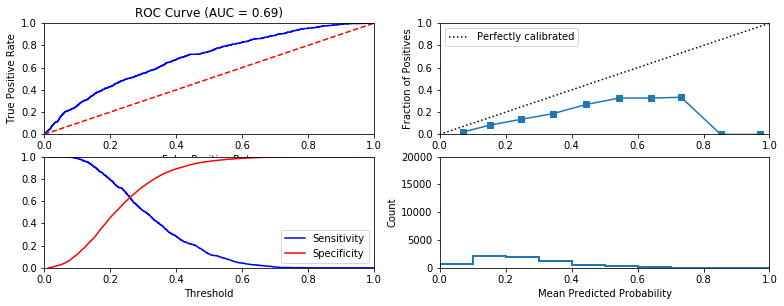


Similarity to LC grade ranking:  0.49276048644691756
Brier score: 0.12830794713879995


{'model': LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
           intercept_scaling=1, max_iter=100, multi_class='warn',
           n_jobs=None, penalty='l2', random_state=None, solver='warn',
           tol=0.0001, verbose=0, warm_start=False),
 'y_pred_labels': array([False,  True, False, ..., False, False,  True]),
 'y_pred_probs': array([0.14871954, 0.5066741 , 0.20862665, ..., 0.44808084, 0.2012802 ,
        0.50765635])}

In [33]:
start_date_train = datetime.date(2016, 1, 1)
end_date_train = datetime.date(2016, 12, 31)
start_date_test = datetime.date(2017, 1, 1)
end_date_test = datetime.date(2017,12,31)

data_dict_test = prepare_data(date_range_train = (start_date_train, end_date_train), 
                         date_range_test = (start_date_test, end_date_test),
                         n_samples_train = 9000, n_samples_test = 7000, feature_subset = your_features_without_de)

## Train and test YOURMODEL using this data

cv_parameters = {'C':[0.01,0.1,1]}
fit_classification(mymodel, data_dict_test,
                          cv_parameters = cv_parameters,
                          model_name = None,
                          random_state = default_seed,
                          output_to_file = False,
                          print_to_screen = True)

## Train and test YOURMODEL on the original data

Fit time: 95.73 seconds
Optimal parameters:
{'max_depth': 3, 'n_estimators': 50}

Accuracy-maximizing threshold was: 0.3201088359740211
Accuracy:  0.79125
              precision    recall  f1-score   support

  No default     0.8017    0.9777    0.8810     15808
     Default     0.5118    0.0880    0.1502      4192

   micro avg     0.7913    0.7913    0.7913     20000
   macro avg     0.6567    0.5329    0.5156     20000
weighted avg     0.7409    0.7913    0.7278     20000



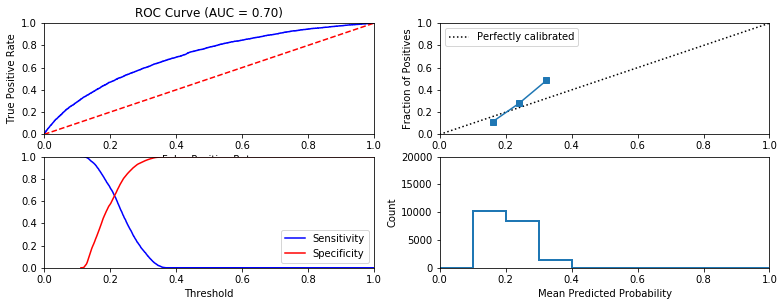


Similarity to LC grade ranking:  0.7336409202720243
Brier score: 0.15533402618006978


{'model': RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
             max_depth=3, max_features='auto', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=None,
             oob_score=False, random_state=None, verbose=0,
             warm_start=False),
 'y_pred_labels': array([False, False, False, ..., False, False, False]),
 'y_pred_probs': array([0.30358891, 0.27663914, 0.15553185, ..., 0.13541179, 0.16672827,
        0.21737178])}

In [23]:
original_features = ['id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate','installment', 'grade',
                    'sub_grade', 'emp_title', 'emp_length', 'home_ownership', 'annual_inc', 'verification_status', 
                    'issue_d', 'loan_status', 'purpose', 'title', 'zip_code', 'addr_state', 'dti', 'total_pymnt', 
                    'delinq_2yrs', 'earliest_cr_line', 'open_acc', 'pub_rec', 'last_pymnt_d', 'last_pymnt_amnt', 
                    'fico_range_high','fico_range_low', 'last_fico_range_high', 'last_fico_range_low',
                   'application_type', 'revol_bal', 'revol_util', 'recoveries']
data_dict_test = prepare_data(feature_subset = original_features)
## Train and test YOURMODEL using this data
mymodel =  RandomForestClassifier()
cv_parameters = {'max_depth': [3,4,5,None],"n_estimators":[50,100,150,200]}


fit_classification(mymodel, data_dict_test,                         
                          model_name = None,
                          cv_parameters = cv_parameters,
                          random_state = default_seed,
                          output_to_file = False,
                          print_to_screen = True)

## Test regression models

In [35]:
def fit_regression(model, data_dict,
                      cv_parameters = {},
                      separate = False, 
                      model_name = None,
                      random_state = default_seed,
                      output_to_file = True,
                      print_to_screen = True):
    '''
    This function will fit a regression model to data and print various evaluation
    measures. It expects the following parameters
      - model: an sklearn model object
      - data_dict: the dictionary containing both training and testing data;
                   returned by the prepare_data function
      - separate: a Boolean variable indicating whether we fit models for 
                  defaulted and non-defaulted loans separately
      - cv_parameters: a dictionary of parameters that should be optimized
                       over using cross-validation. Specifically, each named
                       entry in the dictionary should correspond to a parameter,
                       and each element should be a list containing the values
                       to optimize over      
      - model_name: the name of the model being fit, for printouts
      - random_state: the random seed to use
      - output_to_file: if the results will be saved to the output file
      - print_to_screen: if the results will be printed on screen
    
    This function returns a dictionary FOR EACH RETURN DEFINITION with the following entries
      - model: the best fitted model
      - predicted_return: prediction result based on the test set
      - predicted_regular_return: prediction result for non-defaulted loans (valid if separate == True)
      - predicted_default_return: prediction result for defaulted loans (valid if separate == True)
      - r2_scores: the testing r2_score(s) for the best fitted model
    '''
    
    np.random.seed(random_state)
    
    # --------------------------
    #   Step 1 - Load the data
    # --------------------------
    
    col_list = ['ret_PESS', 'ret_OPT', 'ret_INTa', 'ret_INTb']
    
    X_train = data_dict['X_train']
    filter_train = data_dict['train_set']  

    X_test = data_dict['X_test']
    filter_test = data_dict['test_set']
    out = {}
    
    for ret_col in col_list:
        
        y_train = data.loc[filter_train, ret_col].as_matrix()
        y_test = data.loc[filter_test, ret_col].as_matrix() 

        # --------------------------
        #   Step 2 - Fit the model
        # --------------------------

        if separate:
            outcome_train = data.loc[filter_train, 'outcome']
            outcome_test = data.loc[filter_test, 'outcome']

            # Train two separate regressors for defaulted and non-defaulted loans
            X_train_0 = X_train[outcome_train == False]
            y_train_0 = y_train[outcome_train == False]
            X_test_0 = X_test[outcome_test == False]
            y_test_0 = y_test[outcome_test == False]

            X_train_1 = X_train[outcome_train == True]
            y_train_1 = y_train[outcome_train == True]
            X_test_1 = X_test[outcome_test == True]
            y_test_1 = y_test[outcome_test == True]

            cv_model_0 = GridSearchCV(model, cv_parameters, scoring='r2')
            cv_model_1 = GridSearchCV(model, cv_parameters, scoring='r2')

            start_time = time.time()
            cv_model_0.fit(X_train_0, y_train_0)
            cv_model_1.fit(X_train_1, y_train_1)
            end_time = time.time()

            best_model_0 = cv_model_0.best_estimator_
            best_model_1 = cv_model_1.best_estimator_
            
            if print_to_screen:

                if model_name != None:
                    print("=========================================================")
                    print("  Model: " + model_name + "  Return column: " + ret_col)
                    print("=========================================================")

                print("Fit time: " + str(round(end_time - start_time, 2)) + " seconds")
                print("Optimal parameters:")
                print("model_0:",cv_model_0.best_params_, "model_1",cv_model_1.best_params_)

            predicted_regular_return = best_model_0.predict(X_test)
            predicted_default_return = best_model_1.predict(X_test)
            
            if print_to_screen:
                print("")
                print("Testing r2 scores:")
            # Here we use different testing set to report the performance
            test_scores = {'model_0':r2_score(y_test_0,best_model_0.predict(X_test_0)),
                              'model_1':r2_score(y_test_1,best_model_1.predict(X_test_1))}
            if print_to_screen:
                print("model_0:", test_scores['model_0'])
                print("model_1:", test_scores['model_1'])

            cv_objects = {'model_0':cv_model_0, 'model_1':cv_model_1}
            out[ret_col] = { 'model_0':best_model_0, 'model_1':best_model_1, 'predicted_regular_return':predicted_regular_return,
                      'predicted_default_return':predicted_default_return,'r2_scores':test_scores }

        else:
            cv_model = GridSearchCV(model, cv_parameters, scoring='r2')

            start_time = time.time()
            cv_model.fit(X_train, y_train)
            end_time = time.time()

            best_model = cv_model.best_estimator_
            
            if print_to_screen:
                if model_name != None:
                    print("=========================================================")
                    print("  Model: " + model_name + "  Return column: " + ret_col)
                    print("=========================================================")

                print("Fit time: " + str(round(end_time - start_time, 2)) + " seconds")
                print("Optimal parameters:")
                print(cv_model.best_params_)

            predicted_return = best_model.predict(X_test)
            test_scores = {'model':r2_score(y_test,predicted_return)}
            if print_to_screen:
                print("")
                print("Testing r2 score:", test_scores['model'])

            cv_objects = {'model':cv_model}
            out[ret_col] = {'model':best_model, 'predicted_return':predicted_return, 'r2_scores':r2_score(y_test,predicted_return)}

        # Output the results to a file
        if output_to_file:
            for i in cv_objects:
                # Check whether any of the CV parameters are on the edge of
                # the search space
                opt_params_on_edge = find_opt_params_on_edge(cv_objects[i])
                dump_to_output(model_name + "::" + ret_col + "::search_on_edge", opt_params_on_edge)
                if print_to_screen:
                    print("Were parameters on edge (" + i + ") : " + str(opt_params_on_edge))

                # Find out how different the scores are for the different values
                # tested for by cross-validation. If they're not too different, then
                # even if the parameters are off the edge of the search grid, we should
                # be ok
                score_variation = find_score_variation(cv_objects[i])
                dump_to_output(model_name + "::" + ret_col + "::score_variation", score_variation)
                if print_to_screen:
                    print("Score variations around CV search grid (" + i + ") : " + str(score_variation))

                # Print out all the scores
                dump_to_output(model_name + "::all_cv_scores", str(cv_objects[i].cv_results_['mean_test_score']))
                if print_to_screen:
                    print("All test scores : " + str(cv_objects[i].cv_results_['mean_test_score']) )

                # Dump the AUC to file
                dump_to_output( model_name + "::" + ret_col + "::r2", test_scores[i] )

    return out

### $l_1$ regularized linear regression

In [36]:
## First, trying l1 regularized linear regression with hyper-parameters
from sklearn.linear_model import Lasso

cv_parameters = {'alpha' : np.logspace(-3, 3, 7)}
l1_linear = Lasso()

reg_lasso = fit_regression(model=l1_linear, data_dict=data_dict, model_name='l1')


  Model: l1  Return column: ret_PESS
Fit time: 0.03 seconds
Optimal parameters:
{}

Testing r2 score: -6.002529570725557e-06
Were parameters on edge (model) : False
Score variations around CV search grid (model) : -0.0
All test scores : [-0.09786991]
  Model: l1  Return column: ret_OPT
Fit time: 0.02 seconds
Optimal parameters:
{}

Testing r2 score: -0.00015457825237774614
Were parameters on edge (model) : False
Score variations around CV search grid (model) : -0.0
All test scores : [-0.0089351]
  Model: l1  Return column: ret_INTa
Fit time: 0.02 seconds
Optimal parameters:
{}

Testing r2 score: -1.5217711788695354e-05
Were parameters on edge (model) : False
Score variations around CV search grid (model) : -0.0
All test scores : [-0.08766388]
  Model: l1  Return column: ret_INTb
Fit time: 0.02 seconds
Optimal parameters:
{}

Testing r2 score: -3.2214114308315445e-05
Were parameters on edge (model) : False
Score variations around CV search grid (model) : -0.0
All test scores : [-0.06231

### $l_2$ regularized linear regressor

In [37]:
## trying l2 regularized linear regression with hyper-parameters
## trying l2 regularized linear regression with hyper-parameters
from sklearn.linear_model import Ridge

cv_parameters = {'alpha' : np.logspace(-3, 3, 7)}
l2_linear = Ridge()

reg_ridge = fit_regression(model=l2_linear, data_dict=data_dict, model_name='l2_linear', cv_parameters=cv_parameters)

  Model: l2_linear  Return column: ret_PESS
Fit time: 0.15 seconds
Optimal parameters:
{'alpha': 100.0}

Testing r2 score: 0.012779986811600308
Were parameters on edge (model) : False
Score variations around CV search grid (model) : -0.8538165459145105
All test scores : [-0.09290221 -0.09290206 -0.09290056 -0.09288571 -0.09275065 -0.09211571
 -0.09252811]
  Model: l2_linear  Return column: ret_OPT
Fit time: 0.14 seconds
Optimal parameters:
{'alpha': 10.0}

Testing r2 score: 0.001605098994323595
Were parameters on edge (model) : False
Score variations around CV search grid (model) : -21.32193970728567
All test scores : [-0.00630084 -0.00630079 -0.00630026 -0.00629507 -0.00625279 -0.0062625
 -0.00758601]
  Model: l2_linear  Return column: ret_INTa
Fit time: 0.14 seconds
Optimal parameters:
{'alpha': 1000.0}

Testing r2 score: 0.01041920062299373
Were parameters on edge (model) : True
Score variations around CV search grid (model) : -1.8980339671175588
All test scores : [-0.0848655  -0.08

### Multi-layer perceptron regressor

In [38]:
## trying multi-layer perceptron regression with hyper-parameters

from sklearn.neural_network import MLPRegressor

cv_parameters = {'solver' : ['lbfgs', 'sgd', 'adam'], 'activation' : ['identity', 'logistic', 'tanh', 'relu'], \
                'hidden_layer_sizes' : [(15,), (10, 2), (10, 5, 2), (5, 2)]}

mlp = MLPRegressor()

reg_mlp = fit_regression(model=mlp, data_dict=data_dict, model_name='mlp', cv_parameters=cv_parameters)

  Model: mlp  Return column: ret_PESS
Fit time: 57.15 seconds
Optimal parameters:
{'activation': 'identity', 'hidden_layer_sizes': (15,), 'solver': 'adam'}

Testing r2 score: 0.008849048444651064
Were parameters on edge (model) : True
Score variations around CV search grid (model) : -268.49996126815046
All test scores : [-0.09268629 -0.16639357 -0.07128376 -0.09448615 -0.21309759 -0.13090094
 -0.09577574 -0.22424703 -0.09836315 -0.08963968 -0.26268062 -0.08377384
 -0.09277927 -0.18507205 -0.10280916 -0.10018112 -0.1015139  -0.0831529
 -0.09798602 -0.09758382 -0.09686798 -0.09459375 -0.09894855 -0.10185743
 -0.09328036 -0.25197015 -0.08101826 -0.09387419 -0.24710586 -0.11828675
 -0.09528502 -0.2471005  -0.09711974 -0.09125613 -0.15981157 -0.10184806
 -0.09311457 -0.14021751 -0.09435414 -0.09361166 -0.14375853 -0.09415875
 -0.09261544 -0.10485763 -0.08756762 -0.09778312 -0.14994497 -0.09108662]
  Model: mlp  Return column: ret_OPT
Fit time: 57.87 seconds
Optimal parameters:
{'activation'

### Random forest regressor

In [39]:
## trying random forest regression with hyper-parameters

from sklearn.ensemble import RandomForestRegressor

cv_parameters = {'n_estimators' : [10, 50, 100], 'max_depth' : [3, 4, 5]}
rfreg = RandomForestRegressor()

reg_rf = fit_regression(model=rfreg, data_dict=data_dict, model_name='random forest regressor', cv_parameters=cv_parameters)

  Model: random forest regressor  Return column: ret_PESS
Fit time: 4.91 seconds
Optimal parameters:
{'max_depth': 5, 'n_estimators': 10}

Testing r2 score: 0.011569559332429646
Were parameters on edge (model) : True
Score variations around CV search grid (model) : -2.544923472848813
All test scores : [-0.09353539 -0.09324086 -0.09282898 -0.09442597 -0.09404082 -0.0930226
 -0.09208254 -0.09250929 -0.09246506]
  Model: random forest regressor  Return column: ret_OPT
Fit time: 5.16 seconds
Optimal parameters:
{'max_depth': 5, 'n_estimators': 50}

Testing r2 score: 0.001085888312946981
Were parameters on edge (model) : True
Score variations around CV search grid (model) : -22.04033596752948
All test scores : [-0.00845615 -0.00844894 -0.00829801 -0.00829819 -0.00804471 -0.00781513
 -0.00765049 -0.00692898 -0.00707852]
  Model: random forest regressor  Return column: ret_INTa
Fit time: 5.02 seconds
Optimal parameters:
{'max_depth': 3, 'n_estimators': 50}

Testing r2 score: 0.010395217120665

## Test investment strategies 
Now we test several investment strategies using the learning models above

In [40]:
def test_investments(data_dict,
                        classifier = None,
                        regressor = None,
                        strategy = 'Random', 
                        num_loans = 1000,
                        random_state = default_seed,
                        output_to_file = True):
    '''
    This function tests a variety of investment methodologies and their returns. 
    It will run its tests on the loans defined by the test_set element of the data
    dictionary.
    
    It is currently able to test four strategies
      - random: invest in a random set of loans
      - default-based: score each loan by probability of default, and only invest
                 in the "safest" loans (i.e., those with the lowest probabilities
                 of default)
      - return-based: train a single regression model to predict the expected return
                    of loans in the past. Then, for loans we could invest in, simply
                    rank them by their expected returns and invest in that order.
      - default-& return-based: train two regression models to predict the expected return of
                   defaulted loans and non-defaulted loans in the training set. Then,
                   for each potential loan we could invest in, predict the probability
                   the loan will default, its return if it doesn't default and its
                   return if it does. Then, calculate a weighted combination of
                   the latter using the former to find a predicted return. Rank the
                   loans by this expected return, and invest in that order
    
    It expects the following parameters
      - data_dict: the dictionary containing both training and testing data;
                   returned by the prepare_data function
      - classifier: a fitted model object which is returned by the fit_classification function.
      - regressor: a fitted model object which is returned by the fit_regression function.
      - strategy: the name of the strategy; one of the three listed above
      - num_loans: the number of loans to be included in the test portfolio
      - num_samples: the number of random samples used to compute average return ()   
      - random_state: the random seed to use when selecting a subset of rows
      - output_to_file: if the results will be saved to the output file
      
    The function returns a dictionary FOR EACH RETURN DEFINITION with the following entries
      - strategy: the name of the strategy
      - average return: the return of the strategy based on the testing set
      - test data: the updated Dataframe of testing data. Useful in the optimization section
    '''
    
    np.random.seed(random_state)
    
    # Retrieve the rows that were used to train and test  the
    # classification model
    train_set = data_dict['train_set']
    test_set = data_dict['test_set']
    
    col_list = ['ret_PESS', 'ret_OPT', 'ret_INTa', 'ret_INTb']
    
    # Create a dataframe for testing, including the score
    data_test = data.loc[test_set,:]
    out = {}
    
    for ret_col in col_list:    
    
        if strategy == 'Random':
            # Randomize the order of the rows in the datframe
            data_test = data_test.sample(frac = 1).reset_index(drop = True)

            ## Select num_loans to invest in
            pf_test = num_loans

            ## Find the average return for these loans
            ret_test = data_test[ret_col][:num_loans].mean()

            # Return
            out[ret_col] = {'strategy':strategy, 'average return':ret_test}

            # Dump the strategy performance to file
            if output_to_file:
                dump_to_output(strategy + "," + ret_col + "::average return", ret_test )

            continue
        
        elif strategy == 'Return-based':
            
            colname = 'predicted_return_' + ret_col 

            data_test[colname] = regressor[ret_col]['predicted_return']

            # Sort the loans by predicted return
            data_test = data_test.sort_values(by=colname, ascending = False).reset_index(drop = True)

            ## Pick num_loans loans
            pf_test = num_loans

            ## Find their return
            ret_test = data_test[ret_col][:num_loans].mean()

            # Return
            out[ret_col] = {'strategy':strategy, 'average return':ret_test, 'test data':data_test}

            # Dump the strategy performance to file
            if output_to_file:
                dump_to_output(strategy + "," + ret_col + "::average return", ret_test )

            continue
            
        # Get the predicted scores, if the strategy is not Random or just Regression
        try:
            y_pred_score = classifier['y_pred_probs']
        except:
            y_pred_score = classifier['y_pred_score']

        data_test['score'] = y_pred_score


        if strategy == 'Default-based':
            # Sort the test data by the score
            data_test = data_test.sort_values(by='score').reset_index(drop = True)

            ## Select num_loans to invest in
            pf_test = num_loans

            ## Find the average return for these loans
            ret_test = data_test[ret_col][:num_loans].mean()

            # Return
            out[ret_col] = {'strategy':strategy, 'average return':ret_test}

            # Dump the strategy performance to file
            if output_to_file:
                dump_to_output(strategy + "," + ret_col + "::average return", ret_test )

            continue


        elif strategy == 'Default-return-based':

            # Load the predicted returns
            data_test['predicted_regular_return'] = regressor[ret_col]['predicted_regular_return']
            data_test['predicted_default_return'] = regressor[ret_col]['predicted_default_return']

            # Compute expectation
            colname = 'predicted_return_' + ret_col 
            
            data_test[colname] = ( (1-data_test.score)*data_test.predicted_regular_return + 
                                             data_test.score*data_test.predicted_default_return )

            # Sort the loans by predicted return
            data_test = data_test.sort_values(by=colname, ascending = False).reset_index(drop = True)

            ## Pick num_loans loans
            pf_test =num_loans

            ## Find their return
            ret_test = data_test[ret_col][:num_loans].mean()

            # Return
            out[ret_col] = {'strategy':strategy, 'average return':ret_test, 'test data':data_test}

            # Dump the strategy performance to file
            if output_to_file:
                dump_to_output(strategy + "," + ret_col + "::average return", ret_test )

            continue

        else:
            return 'Not a valid strategy'
        
    return out

In [43]:
## Test investment strategies using the best performing regressor

col_list = ['ret_PESS', 'ret_OPT', 'ret_INTa', 'ret_INTb']
test_strategy = 'Random'

print('strategy:',test_strategy)  
strat_rand_returns = []

for seed in range(1, 101):
    returns = []
    strat_rand = test_investments(data_dict,
                        classifier = None,
                        regressor = None,
                        strategy = 'Random', 
                        num_loans = 1000,
                        random_state = seed,
                        output_to_file = False)
    for ret_col in col_list:
        returns.append(strat_rand[ret_col]['average return'])
    strat_rand_returns.append(returns)

strat_rand_returns = np.array(strat_rand_returns)
avg_strat_rand_returns = np.mean(strat_rand_returns, axis=0)

for i in range(len(col_list)):
    print(col_list[i] + ': ' + str(avg_strat_rand_returns[i]))

strategy: Random
ret_PESS: 0.007817219839299448
ret_OPT: 0.05051365532647182
ret_INTa: 0.014363142896454484
ret_INTb: 0.06042970263950386


In [44]:
test_strategy = 'Default-based'


print('strategy:',test_strategy)
strat_def_returns = []

for seed in range(1, 101):
    returns = []
    strat_def = test_investments(data_dict,
                            classifier =l2_logistic,
                            regressor = None,
                            strategy = 'Default-based', 
                            num_loans = 1000,
                            random_state = seed,
                            output_to_file = False)
    for ret_col in col_list:
        returns.append(strat_def[ret_col]['average return'])
    strat_def_returns.append(returns)


strat_def_returns = np.array(strat_def_returns)
avg_strat_def_returns = np.mean(strat_def_returns, axis=0)

for i in range(len(col_list)):
    print(col_list[i] + ': ' + str(avg_strat_def_returns[i]))

strategy: Default-based
ret_PESS: 0.017736219983712713
ret_OPT: 0.05210675992569737
ret_INTa: 0.01482569280811112
ret_INTb: 0.061411446911719514


In [47]:
test_strategy = 'Return-based'

print('strategy:',test_strategy)
strat_ret_returns = []

for seed in range(1, 101):
    returns = []
    strat_ret = test_investments(data_dict,
                            classifier =None,
                            regressor = reg_ridge,
                            strategy = 'Return-based', 
                            num_loans = 1000,
                            random_state = seed,
                            output_to_file = False)
    for ret_col in col_list:
        returns.append(strat_ret[ret_col]['average return'])
        strat_ret_returns.append(returns)

strat_ret_returns = np.array(strat_ret_returns)
avg_strat_ret_returns = np.mean(strat_ret_returns, axis=0)
        
for i in range(len(col_list)):
    print(col_list[i] + ': ' + str(avg_strat_ret_returns[i]))

strategy: Return-based
ret_PESS: 0.00932574942976372
ret_OPT: 0.048720131199452794
ret_INTa: 0.02010663611472728
ret_INTb: 0.058697621940985295


In [48]:
test_strategy = 'Default-return-based'

## For the Default-return-based strategy we need to fit a new regressor with separate = True
model=Ridge()

cv_parameters = {'alpha' : np.logspace(-3, 3, 7)}


strat_defret_returns = []

for seed in range(1, 101):
    returns = []
    reg_separate = fit_regression(model, data_dict,
                          cv_parameters = cv_parameters,
                          separate = True, 
                          model_name = None,
                          random_state = seed,
                          output_to_file = False,
                          print_to_screen = False)

    strat_defret = test_investments(data_dict,
                            classifier =l2_logistic,
                            regressor = reg_separate,
                            strategy = 'Default-return-based', 
                            num_loans = 1000,
                            random_state = seed,
                            output_to_file = False)
    for ret_col in col_list:
        returns.append(strat_defret[ret_col]['average return'])
        strat_defret_returns.append(returns)

print('strategy:',test_strategy)

strat_defret_returns = np.array(strat_defret_returns)
avg_strat_defret_returns = np.mean(strat_defret_returns, axis=0)
        
for i in range(len(col_list)):
    print(col_list[i] + ': ' + str(avg_strat_defret_returns[i]))

strategy: Default-return-based
ret_PESS: 0.00826338416373715
ret_OPT: 0.048243787153360834
ret_INTa: 0.01258582181392054
ret_INTb: 0.05900618650196535


## Sensitivity test of portfolio size

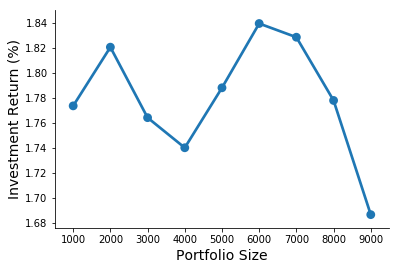

In [59]:
## Test the best-performing data-driven strategy on different portfolio sizes

result_sensitivity = []

## Vary the portfolio size from 1,000 to 10,000
for num_loans in list(range(1000,10000,1000)):

    for seed in range(1, 101):
        returns = []
        reg_0 = test_investments(data_dict,
                            classifier =l2_logistic,
                            regressor = None,
                            strategy = 'Default-based', 
                            num_loans = num_loans,
                            random_state = seed,
                            output_to_file = False)
        returns.append(reg_0['ret_PESS']['average return'])
    
    returns = np.array(returns)
    avg_return = np.mean(returns)
    result_sensitivity.append(avg_return)
    
result_sensitivity = np.array(result_sensitivity) * 100
sns.pointplot(np.array(list(range(1000,10000,1000))),result_sensitivity)
sns.despine()
plt.ylabel('Investment Return (%)',size = 14)
plt.xlabel('Portfolio Size',size = 14)
plt.show()

In [54]:
print('Best possible return in hindsight under M1: {}'.format(np.mean(data['ret_PESS'].nlargest(1000))))

Best possible return in hindsight under M1: 0.14361874335422803


In [55]:
print('Best possible return in hindsight under M2: {}'.format(np.mean(data['ret_OPT'].nlargest(1000))))

Best possible return in hindsight under M2: 0.409636971347599


In [57]:
print('Best possible return in hindsight under M3(2.4%): {}'.format(np.mean(data['ret_INTa'].nlargest(1000))))

Best possible return in hindsight under M3(2.4%): 0.15074682857061947


In [58]:
print('Best possible return in hindsight under M3(6%): {}'.format(np.mean(data['ret_INTb'].nlargest(1000))))

Best possible return in hindsight under M3(6%): 0.2035622796605052


In [1]:
import numpy as np

In [2]:
a=[[1,2,3],[4,5,6]]

In [3]:
a

[[1, 2, 3], [4, 5, 6]]

In [5]:
np.mean(np.array(a),axis=0)

array([2.5, 3.5, 4.5])